<a href="https://colab.research.google.com/github/markcastorm/Cognitive-Modelling-using-Haxby-data/blob/main/Cognitive_Modelling_using_Haxby_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Haxby data Description
"""
Experimental View of the Haxby (Faces and Objects in Ventral Temporal Cortex (fMRI)) Dataset:
This is a block-design fMRI dataset (Haxby) from a study on face and object representation in
human ventral temporal cortex. It consists of 6 subjects with 12 runs per subject.
In each run, the subjects passively viewed greyscale images of eight object categories,
grouped in 24s blocks separated by rest periods. Each image was shown for 500ms
and was followed by a 1500ms inter-stimulus interval.
Full-brain fMRI data were recorded with a volume repetition time of 2.5s,
thus,a stimulus block was covered by roughly 9 volumes.

---
Dataset Description
1. anat.nii.gz
- High resolution anatomical image. For subject 6 there is no anatomical image available.
2.bold.nii.gz
    
- 4D fMRI timeseries image. (1452 volumes with 40 x 64 x 64 voxels,
corresponding to a voxel size of 3.5 x 3.75 x 3.75 mm and
a volume repetition time of 2.5 seconds).
The timeseries contains all 12 runs of the original experiment,
concatenated in a single file. Please note, that the timeseries signal is not detrended.
3.mask*.nii.gz
- Various masks in functional space provided by the original authors.
“vt” refers to “ventral temporal”, “face” and “house” masks are GLM contrast based localizer maps.
4.labels.txt
- A two-column text file with the stimulation condition and the corresponding experimental run for
each volume in the timeseries image. Labels are given in literal form (e.g. ‘face’).
---
We have 8 different stimuli categories that are :
scissors, face, cat, scrambledpix, bottle, chair, shoe, house.
We'll work with haxby dataset that can be downloaded directly from the neuroimaging library Nilearn.
There are 6 subjects in the experiment that will be downloaded seperately with their fMRI images and masks.
These fMRI images are 4-D nifti images.
"""

First thing first, we need to install the necessary Python packages and download the Haxby dataset from the web using “nilearn” framework

In [ ]:
!pip install umap
!pip install pipreqs
!pip install lazypredict
!pip install nibabel
!pip install nilearn
!pip install -Ukaleido
!pip install umap-learn
!pip install Pillow

try:
  import sklearn
  print('Scikit-learn is available, version', sklearn.__version__)
except:
  !pip install scikit-learn

try:
  import numpy as np
  print('Numpy is available, version', np.__version__)

except:
  !pip install numpy

try:
  import pandas as pd
  Print('Pandas is available, version', pd.__version__)

except:
  !pip install pandas

try:
  import scipy
  print('Scipy is available, version',scipy.__version__)

except:
  !pip install scipy
try:
  import plotly
except:
  !pip install plotly




Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -k
Scikit-learn is available, version 1.2.2
Numpy is available, version 1.23.5
Scipy is available, version 1.11.3


Now let's import necessary packages

In [ ]:
from __future__ import print_function, division

#Basics
import matplotlib.pyplot as plt
import os,random, time, sys, copy, math, pickle

#interactive mode
plt.ion()

#Lets ignore warnings
import warnings
warnings.filterwarnings("ignore")

#potting
import plotly.io as plt_io
import plotly.graph_objects as go
%matplotlib inline

#Dimension Reduction Algorithms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
import umap

#Transformations
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Metrics
from sklearn.metrics import classification_report

#Train-Test
from sklearn.model_selection import train_test_split

#Classical ML algorithm
from lazypredict.Supervised import LazyClassifier

#Utilities
from tqdm import tqdm

#distance mesurements
from scipy.spatial.distance import cdist
#Extras
from abc import abstractmethod
from typing import Callable, Iterable, List, Tuple

COLAB = True

if COLAB:
    # To access Google Drive:
    from google.colab import drive
    drive.mount("/content/gdrive")


#for the neuroimaging
from nibabel.testing import data_path
from nilearn import plotting as nplt
from nilearn.input_data import NiftiMasker
from nilearn import datasets
from nilearn import plotting
from nilearn.image import mean_img
from nilearn.image import index_img
import nibabel as nib
from nilearn import image

# Update root_dir to the mounted Google Drive path
root_dir = "/content/gdrive/My Drive"
image_results_dir = os.path.join(root_dir, 'images')
results_dir = os.path.join(root_dir, 'results')

print('Working Directory:\n', root_dir)

#creating a requirement.txt file
!pip3 freeze > requirements.txt



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Working Directory:
 /content/gdrive/My Drive


Lets have look at the Haxby dataset
we have:
    
    anat: Anatomical structure of fMRI data
    func: Nifti Images of fMRI data (Will be converted NumPy Matrix)
    session_target: Files corresponds to our target variable (Will be discussed later)
    mask, mask_vt, mask_faces, … (Different spatial masks for extracting activated areas in ventral temporal cortex)

In [ ]:
# There are 6 number of subjects in the experiment:
haxby_dataset = datasets.fetch_haxby(subjects= [1,2,3,4,5,6])

In [ ]:
haxby_dataset

{'anat': ['/root/nilearn_data/haxby2001/subj1/anat.nii.gz',
  '/root/nilearn_data/haxby2001/subj2/anat.nii.gz',
  '/root/nilearn_data/haxby2001/subj3/anat.nii.gz',
  '/root/nilearn_data/haxby2001/subj4/anat.nii.gz',
  '/root/nilearn_data/haxby2001/subj5/anat.nii.gz',
  None],
 'func': ['/root/nilearn_data/haxby2001/subj1/bold.nii.gz',
  '/root/nilearn_data/haxby2001/subj2/bold.nii.gz',
  '/root/nilearn_data/haxby2001/subj3/bold.nii.gz',
  '/root/nilearn_data/haxby2001/subj4/bold.nii.gz',
  '/root/nilearn_data/haxby2001/subj5/bold.nii.gz',
  '/root/nilearn_data/haxby2001/subj6/bold.nii.gz'],
 'session_target': ['/root/nilearn_data/haxby2001/subj1/labels.txt',
  '/root/nilearn_data/haxby2001/subj2/labels.txt',
  '/root/nilearn_data/haxby2001/subj3/labels.txt',
  '/root/nilearn_data/haxby2001/subj4/labels.txt',
  '/root/nilearn_data/haxby2001/subj5/labels.txt',
  '/root/nilearn_data/haxby2001/subj6/labels.txt'],
 'mask_vt': ['/root/nilearn_data/haxby2001/subj1/mask4_vt.nii.gz',
  '/root/n

Now lets print the filenames ofthe fMRI data of the subjecs

In [ ]:
num_subjects = 6

for subject in range(num_subjects):

    # 'func' is a list of filenames: one for each subject
    fmri_filename = haxby_dataset.func[subject]

    # print basic information on the dataset
    print('Subject functional nifti images (4D) are at: %s' %
          fmri_filename)  # 4D data

Subject functional nifti images (4D) are at: /root/nilearn_data/haxby2001/subj1/bold.nii.gz
Subject functional nifti images (4D) are at: /root/nilearn_data/haxby2001/subj2/bold.nii.gz
Subject functional nifti images (4D) are at: /root/nilearn_data/haxby2001/subj3/bold.nii.gz
Subject functional nifti images (4D) are at: /root/nilearn_data/haxby2001/subj4/bold.nii.gz
Subject functional nifti images (4D) are at: /root/nilearn_data/haxby2001/subj5/bold.nii.gz
Subject functional nifti images (4D) are at: /root/nilearn_data/haxby2001/subj6/bold.nii.gz


### Neuroimaging Analysis

Now we can start the visualization process.
#### 4-D Visialization of fMRI volume and EPI
Now we will visualize the Echo Planar imaging for the subjucts of Haxby data from the frontal, axial, and  lateral regions.This will provide a realistic insights from the active regions of the brain wich play an important role in spatio-temporal brain decoding


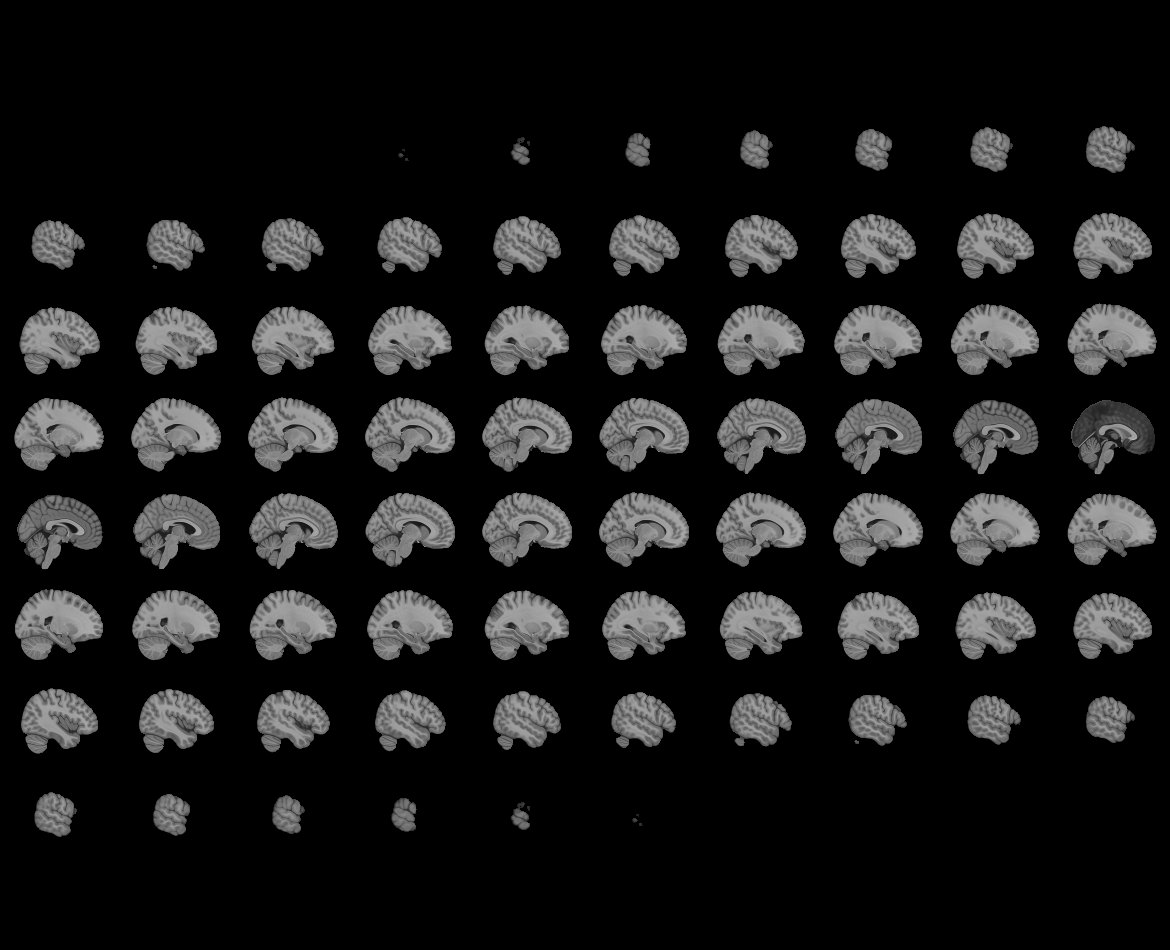
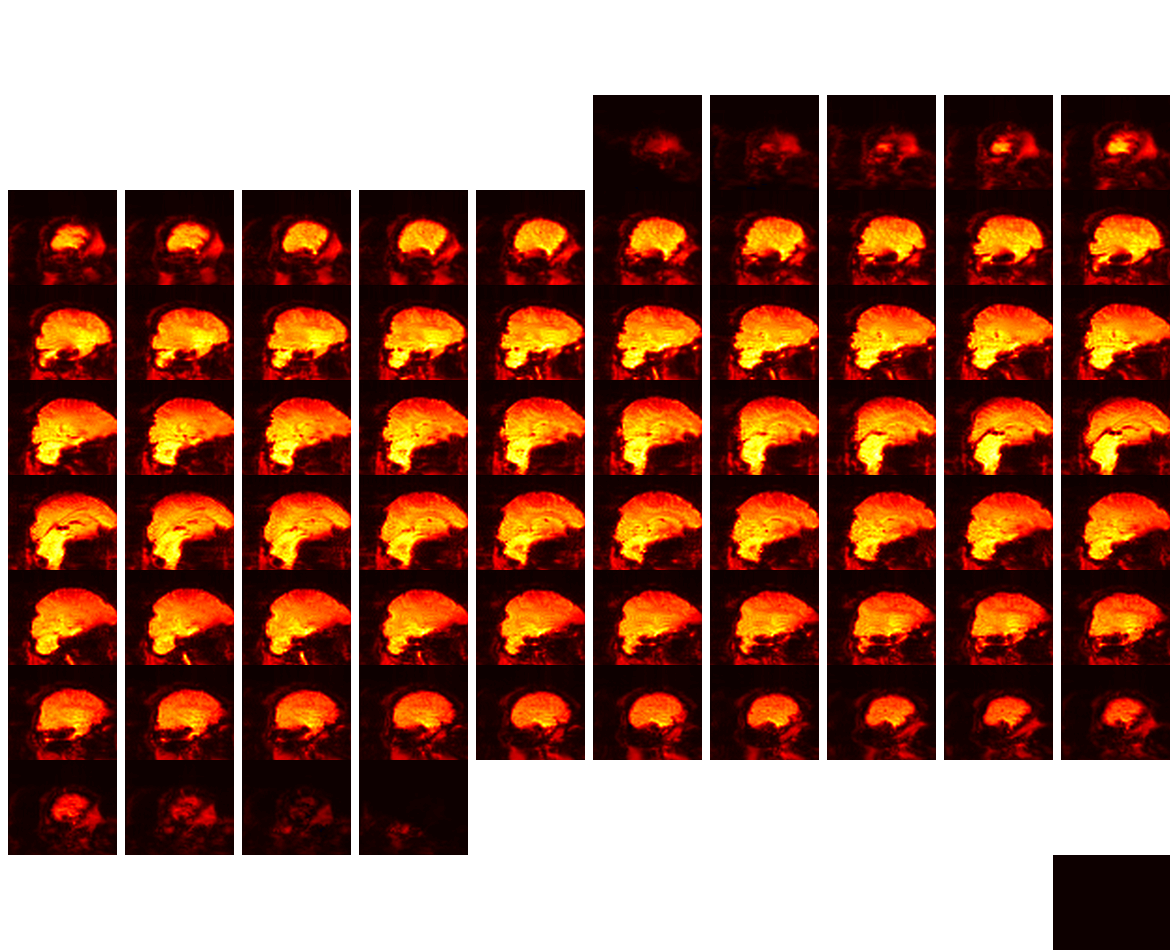

In [ ]:
 Cexplanatory_fMRI_dir =os.path.join(image_results_dir, 'explanatory')

#Lets see the cut in the x-direction
sagittal = -25
#Lets see the cut in the x-direction
coronal = -37
#Lets see the cut in the z-direction
axial = -6

#Now the displaying coordinated to be in a list
cut_coords = [sagittal, coronal, axial]

#Echo-planarimaging Averaged for 4-D
epi_image = mean_img(fmri_filename)

plotting.view_img(epi_image,
                  threshold=None,
                  title = 'fMRI Volume',
                  output_file = os.path.join(explanatory_fMRI_dir + 'fMRI_volume.png'),
                  )


As we have a 4D image, that is brain volumes acquired over time (the 4th dimension), we need to adapt the plotting a bit. More precisely, we need to either plot a 3D image at a given time point or e.g. compute the mean image over time and plot that.

In [ ]:
func_image_mean = mean_img(fmri_filename)
func_image_mean.dataobj.shape

(40, 64, 64)

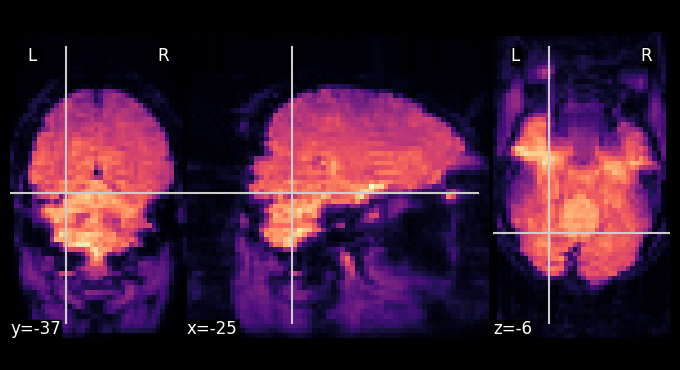

In [ ]:
plotting.plot_epi(func_image_mean,
                  cut_coords=cut_coords,
                  cmap='magma')
plt.show()

In [ ]:
from nilearn import plotting
from nilearn.image import mean_img


# Plotting
plotting.view_img(func_image_mean, cmap='magma', symmetric_cmap=False).open_in_browser()

Lets make it interactive

In [ ]:
plotting.view_img(func_image_mean, cmap='magma', symmetric_cmap=False)
plotting.show()

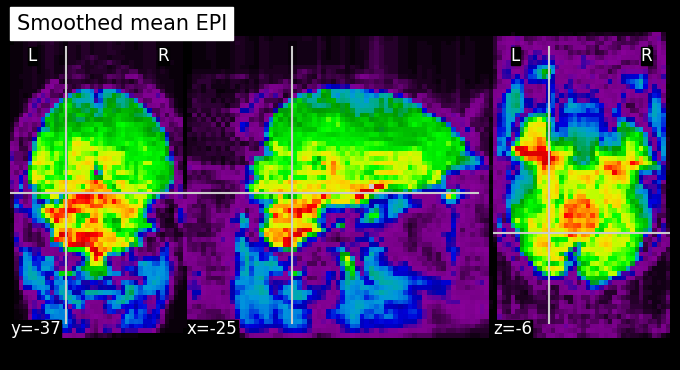

In [ ]:
# Check if the directory exists and create it if necessary
if not os.path.exists(explanatory_fMRI_dir):
    os.makedirs(explanatory_fMRI_dir)
    print(f"Created directory: {explanatory_fMRI_dir}")

# Plot and save the image
plotting.plot_epi(mean_img(fmri_filename),
                  title='Smoothed mean EPI',
                  cut_coords=cut_coords,
                  #output_file=os.path.join(explanatory_fMRI_dir, 'epi.png')
                  )
plt.show()

Region of Interest Analysis
This involves the extaction of signals from specified areas.ROI Analysis is to explore the underlying signal a whole-brain voxel analysis.

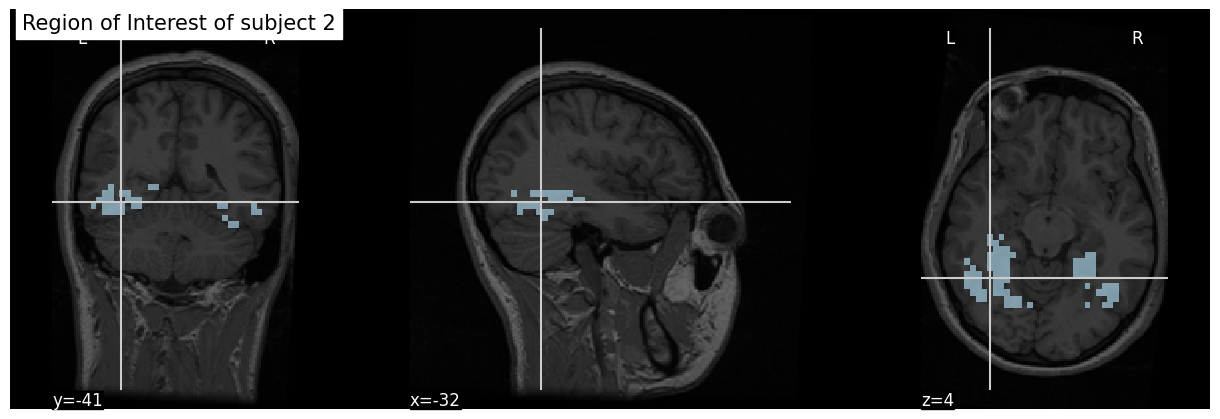

In [ ]:
def RoI_visualizer(haxby_dataset = haxby_dataset, subject_id:int = random.randint(0,5)) -> None:


    # Subject ID from i = 0,...,5:
    # subject_id = 3

    # Get mask filename:
    mask_filename = haxby_dataset.mask_vt[subject_id]


    # Region of Interest Visualizations:
    plotting.plot_roi(mask_filename,
                      bg_img=haxby_dataset.anat[subject_id],
                      cmap='Paired',
                      title = f'Region of Interest of subject {subject_id}',
                      figure= plt.figure(figsize=(12,4)),
                      alpha=0.7,
                      #output_file = os.path.join(explanatory_fMRI_dir, 'roi.png'),
                      )

    plotting.show()

RoI_visualizer(subject_id=2)

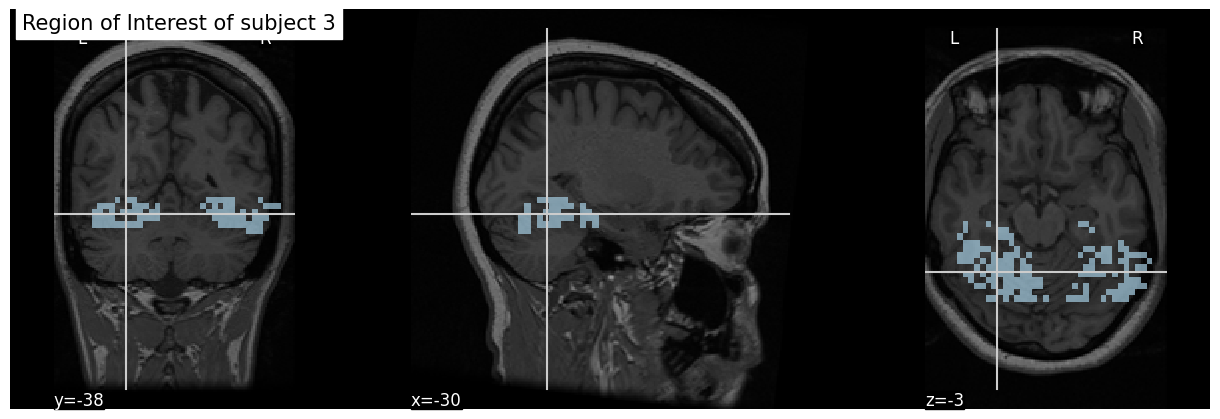

In [ ]:
RoI_visualizer(subject_id=3)

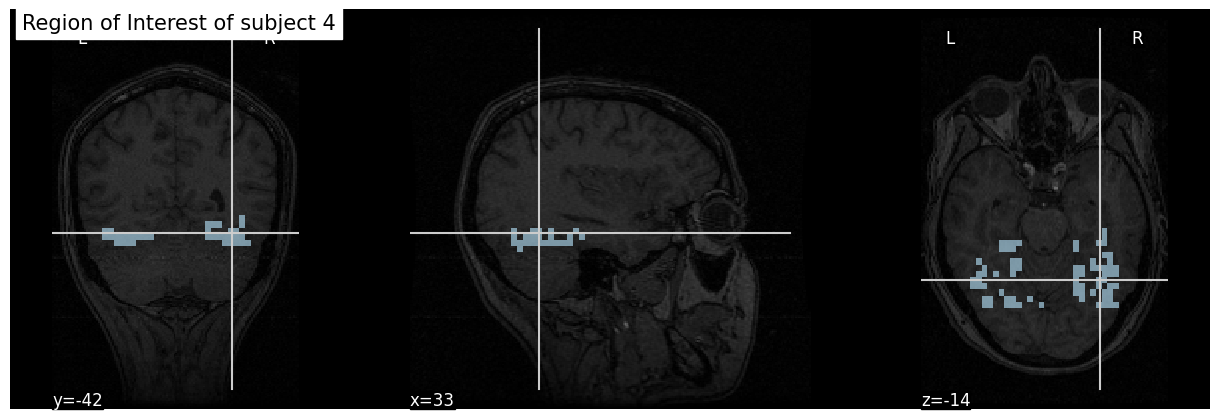

In [ ]:
RoI_visualizer(subject_id=4)

### Statistical Maps
Statistical Parametric Mapping refers to the construction adn assessment of spatially extended statistical processes used to test the hypothesis about functional imaging data.
 Generally, the prior step in statistical fMRI is to create a thresholded statistical map, representing the regions that are active (above a threshold). Hence, it is useful in examining differences in brain activity recorded during neuroscientific experiments.

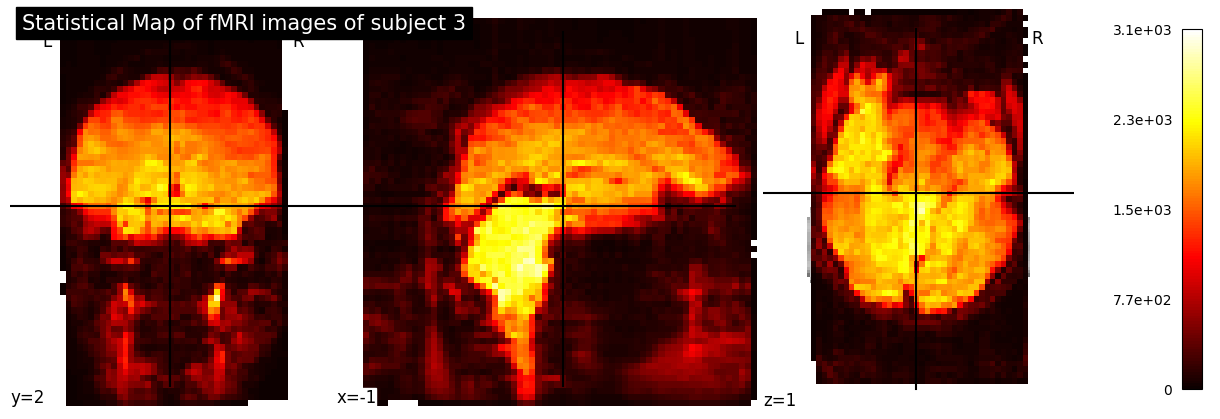

In [ ]:
subject_id = 3

plotting.plot_stat_map(mean_img(fmri_filename),
                       threshold=3,
                       figure=plt.figure(figsize=(12,4)),
                       title=f'Statistical Map of fMRI images of subject {subject_id}',
                       #output_file = os.path.join(explanatory_fMRI_dir, 'stats_map.png')
                       )
plt.show()

###Direct fMRI Visualizations
Simple and complex visualization of fMRI data is quite an iportant area in the context of neuroimaging since it enables researchers to view cortical brain activity.
Here we will plot  the temporally averaged fMRI data of subject 2 to further visualization


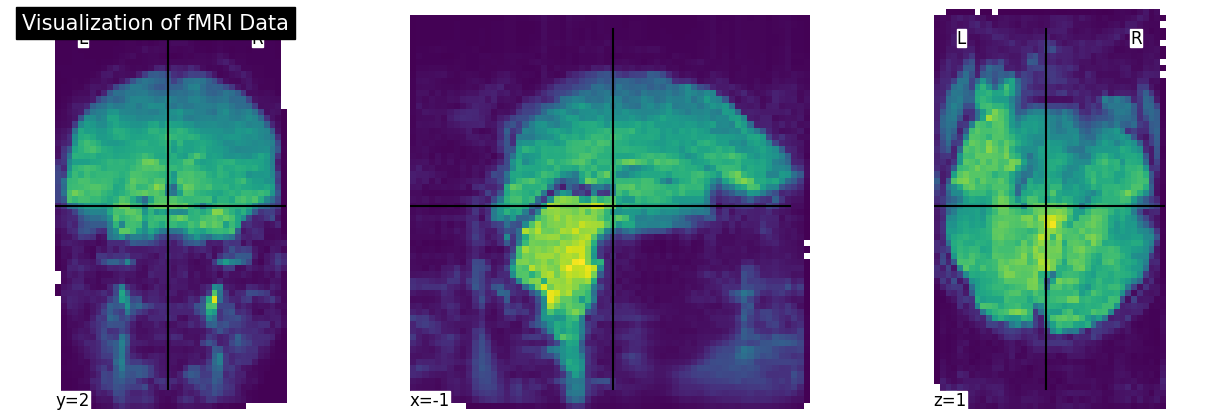

In [ ]:
plotting.plot_img(mean_img(fmri_filename),
                 cut_coords=None,
                 #output_file= os.path.join(explanatory_fMRI_dir, 'fMRI.png'),
                 display_mode='ortho',
                 figure=plt.figure(figsize = (12,4)),
                 axes=None,
                 title='Visualization of fMRI Data',
                 threshold=3,
                 annotate=True,
                 draw_cross=True,
                 black_bg=False,
                 colorbar=False)
plt.show()

Anatomic Visualizations
Here we visualize the anatomical structure of fMRI obtained by the temporally averaged fMRI data of subject 2 to generate insights befor decoding

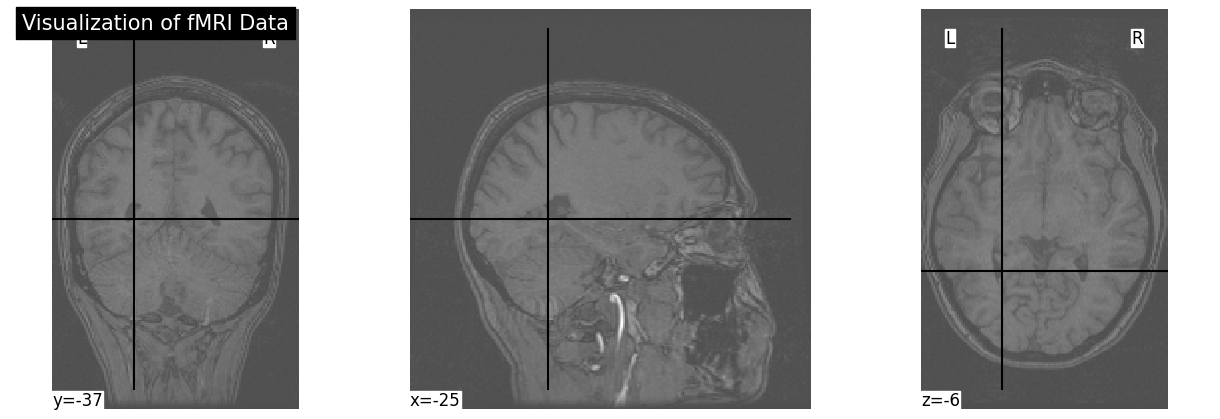

In [ ]:
plotting.plot_anat(haxby_dataset.anat[0],
                   cut_coords = cut_coords,
                   #output_file = os.path.join(explanatory_fMRI_dir, 'anat.png'),
                   display_mode = 'ortho',
                   figure = plt.figure(figsize = (12,4)),
                   axes = None,
                   title = 'Visualization of fMRI Data',
                   threshold = None,
                   annotate = True,
                   draw_cross = True,
                   black_bg=False,
                   colorbar=False
                   )
plotting.show()

###Glass Brain
This is a state-of-art real-time brain visualization technology by Unity3D game engine that its inputs include an individuals brain structure both tissue,and fiber tract architecture,obtained fromhigh-resolution MRI-DTI brain scans.Here we will project frontal, axial,and lateral sided of temporally avaraged fMRI data osf subject 5

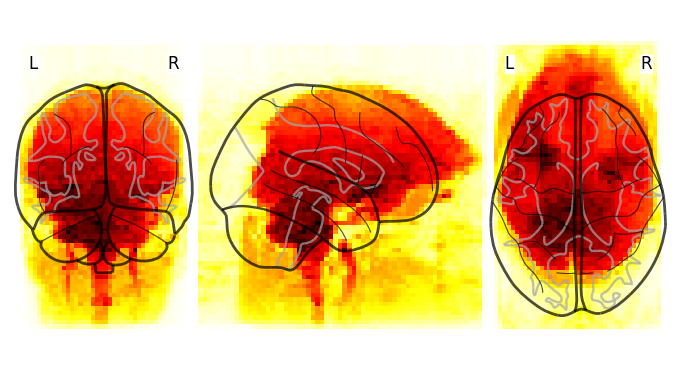

In [ ]:
plotting.plot_glass_brain(mean_img(fmri_filename),
                          threshold=3,
                          #output_file= os.path.join(explanatory_fMRI_dir, 'glass_brain_white.png')
                          )
plotting.show()



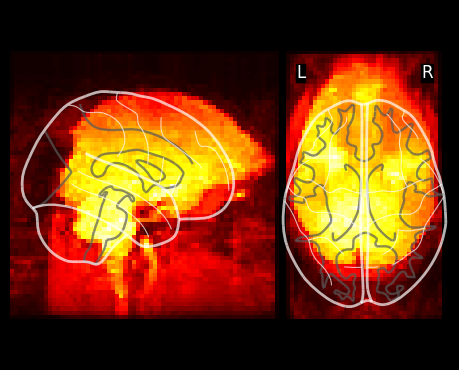

In [ ]:
plotting.plot_glass_brain(
    mean_img(fmri_filename),
    black_bg=True,
    display_mode='xz',
    threshold=None,
    #output_file= os.path.join(explanatory_fMRI_dir, 'glass_brain_black.png')
   )

plotting.show()

Now lets visualize the data in an interactive 3D fashion

Enabling interactivity in colab

In [ ]:
%matplotlib notebook

In [ ]:
plotting.view_img_on_surf(mean_img(fmri_filename),
                          threshold='90%',
                          surf_mesh='fsaverage',
                          )
plotting.show()

In [ ]:
plotting.view_img_on_surf(mean_img(fmri_filename),
                          threshold='70%',
                          surf_mesh='fsaverage',
                          )
plotting.show()

In [ ]:
# Save the plot as an HTML file
view = plotting.view_img_on_surf(func_image_mean, threshold='90%', surf_mesh='fsaverage')
view.save_as_html("interactive_plot.html")

# Open the HTML file in a new tab
from IPython.display import HTML
HTML(filename="interactive_plot.html")

In [ ]:
import plotly.express as px
from nilearn import plotting
from nilearn.image import mean_img


# Compute the mean image
func_image_mean = mean_img(fmri_filename)

# Check the shape of the mean image
print(func_image_mean.shape)

# Get data from the image
data_3d = func_image_mean.get_fdata()

# Use plotly to create a 3D surface plot
fig = px.imshow(data_3d[:, :, data_3d.shape[2] // 2], color_continuous_scale='magma')

# Show the plot
fig.show()


##Functional Connectivity and Similarity Analysis

First lets manipulate the Haxby dataset and apply ventrall temporal masks to extract signals from the regionsof the human brain


In [ ]:
haxby_dataset = datasets.fetch_haxby(subjects= [1,2,3,4,5,6])

Loading behavioral Information

In [ ]:
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
behavioral.head()

In [ ]:
behavioral.head(n=40)

Visual Stimuli Categories

In [ ]:
for stimuli in np.unique(behavioral['labels']).tolist():
  print(stimuli)

We can see the information provided indicates what category participants percieved at which sample or fMRIimage aquisition / point in time during the experiment

In [ ]:
behavioral.head(n=40)

labels  chunks
0       rest       0
1       rest       0
2       rest       0
3       rest       0
4       rest       0
5       rest       0
6   scissors       0
7   scissors       0
8   scissors       0
9   scissors       0
10  scissors       0
11  scissors       0
12  scissors       0
13  scissors       0
14  scissors       0
15      rest       0
16      rest       0
17      rest       0
18      rest       0
19      rest       0
20      rest       0
21      face       0
22      face       0
23      face       0
24      face       0
25      face       0
26      face       0
27      face       0
28      face       0
29      face       0
30      rest       0
31      rest       0
32      rest       0
33      rest       0
34      rest       0
35       cat       0
36       cat       0
37       cat       0
38       cat       0
39       cat       0

Letsperform stimuli Visualization

for each image category, a number of scrambled images were also presented.

In [ ]:
from nilearn import datasets
import matplotlib.pyplot as plt

haxby_dataset_stimuli = datasets.fetch_haxby(subjects=[], fetch_stimuli=True)
stimulus_information = haxby_dataset_stimuli.stimuli

for stimulus_type in [*stimulus_information]:
    if stimulus_type != 'controls':
        img_paths = stimulus_information[stimulus_type]

        fig, axes = plt.subplots(2, len(img_paths)//2, figsize=(15, 5))
        fig.suptitle(stimulus_type)

        for img_path, ax in zip(img_paths, axes.ravel()):
            image = plt.imread(img_path)
            ax.imshow(image, cmap='gray')
            ax.axis('off')

        plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install Pillow


In [ ]:
import matplotlib.pyplot as plt
from nilearn import datasets
from PIL import Image
from IPython.display import display

# Fetch the Haxby dataset
haxby_dataset_stimuli = datasets.fetch_haxby(subjects=[], fetch_stimuli=True)
stimulus_information = haxby_dataset_stimuli.stimuli

for stim_type in stimulus_information:
    # Skip control images, there are too many
    if stim_type != 'controls':
        file_names = stimulus_information[stim_type]
        file_names = file_names[0:16]
        fig, axes = plt.subplots(4, 4, figsize=(10, 10))
        fig.suptitle(stim_type)

        for img_path, ax in zip(file_names, axes.ravel()):
            img = plt.imread(img_path)
            ax.imshow(img, cmap=plt.cm.gray)
            ax.axis("off")

            # Convert the NumPy array to a PIL Image and display
            pil_img = Image.fromarray((img * 255).astype('uint8'))
            display(pil_img)

        plt.show()


In [ ]:
import matplotlib.pyplot as plt
from nilearn import datasets
from PIL import Image
from IPython.display import display

# Fetch the Haxby dataset
haxby_dataset_stimuli = datasets.fetch_haxby(subjects=[], fetch_stimuli=True)
stimulus_information = haxby_dataset_stimuli.stimuli

for stim_num in range(len(stimulus_information['controls'])):
    stim_type = stimulus_information['controls'][stim_num][0]
    file_names = stimulus_information['controls'][stim_num][1]
    file_names = file_names[0:16]
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.suptitle(stim_type)

    for img_path, ax in zip(file_names, axes.ravel()):
        img = plt.imread(img_path)
        ax.imshow(img, cmap=plt.cm.gray)
        ax.axis("off")

        # Convert the NumPy array to a PIL Image and display
        pil_img = Image.fromarray((img * 255).astype('uint8'))
        display(pil_img)

    plt.show()


We can see there are 8 categories

In [ ]:
stimuli_categories = [
    'scissors',
    'face',
    'cat',
    'scrambledpix',
    'bottle',
    'shoe',
    'chair',
    'house'
]

There are 864 sample that are connected temporally the time-series data

In [ ]:
for subject_id in range(num_subjects):
    label = pd.read_csv(haxby_dataset.session_target[subject_id], delimiter=' ')

    # Creating conditional categories:
    conditions = behavioral['labels']

    condition_mask = conditions.isin(stimuli_categories).tolist()
    conditions = conditions[condition_mask]

    # Convert to numpy array
    conditions = conditions.values
    print(conditions.shape)



(864,)
(864,)
(864,)
(864,)
(864,)
(864,)


We can see that all 864 time series data

Let's perform masking to extract the region of interest to reduce the dimensionality of fMRI

In [ ]:
#Create a stimuli to category tocategory to stimuli:
stimuli2category = {
                'scissors'      : 0,
                'face'          : 1,
                'cat'           :2,
                'scrambledpix'  :3,
                'bottle'        :4,
                'chair'         :5,
                'shoe'          :6,
                'house'         :7
}

category2stimuli = {category:stimuli for stimuli, category in stimuli2category.items()}

In [ ]:
# Creating conditional categories:
conditions = behavioral['labels']

# We ignore rest condition:
condition_mask = conditions.isin(stimuli_categories).tolist()


fmri_niimgs = index_img(fmri_filename, condition_mask)

conditions = conditions[condition_mask]

# Convert to numpy array
conditions = conditions.values
print(conditions.shape)

(864,)


Spatio Temporal Masking

In [ ]:
def fetch_haxby_per_subject(subject_id:int = None,standardize:bool = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """

        Given the subject id, fetch the haxby data in matrix format.

        Arguments:
            - subject_id  (int) : Subject number from [1,6]
            - standardize (bool): If true, masks are standardized

        Returns:
            - data (Tuple[np.ndarray, np.ndarray, np.ndarray]) = Original 4-D data, Flattened + Masked Data, Label

    """

    # Getting the data file name:
    spatio_temporal_data_path = haxby_dataset.func[subject_id]

    # Getting labels:
    behavioral = pd.read_csv(haxby_dataset.session_target[subject_id], delimiter = ' ')

    # Creating conditional categories:
    conditions = behavioral['labels']

    # Creating masks for stimuli categories, (ignores rest conditions)
    condition_mask = conditions.isin([*stimuli2category]).tolist()

    # Appylying masks to labels (categorical):
    conditions = conditions[condition_mask]

    # Creating labels series (numerical):
    categories = np.array([stimuli2category[stimulus] for stimulus in conditions])

    # Masking fMRI images: (shape = (40, 64, 64, 864))
    fmri_niimgs = index_img(spatio_temporal_data_path, condition_mask)

    # Converting NumPy and transposing to (864, 40, 64, 64):
    numpy_fmri = fmri_niimgs.get_data().transpose(3,0,1,2)

    masker = NiftiMasker(mask_img=haxby_dataset.mask_vt[subject_id],
                         smoothing_fwhm=4,
                         standardize=standardize,
                         memory='nilearn_cache',
                         memory_level=1)

    masked = masker.fit_transform(fmri_niimgs)


    return numpy_fmri,  masked, categories

In [ ]:
category2stimuli = {category:stimuli for stimuli, category in stimuli2category.items()}

In [ ]:
# (temporal dimension, spatial dimension 1, spatial dimension 2, # of experiments)
fmri_niimgs.get_data().shape

(40, 64, 64, 864)

 this function will enable us to

    Fetch fMRI data and convert it into NumPy matrix
    Create and apply spatio-temporal masks to extract regions of interests
    Prepare the supervisions (target/labels

In [ ]:
!pip install joblib

In [ ]:
from joblib import dump, load

data = [fetch_haxby_per_subject(subject_id) for subject_id in range(num_subjects)]
fmri_imgs_mat, masks, categories = list(zip(*data))

# Save the data using joblib
dump(fmri_imgs_mat, 'fMRI_data.joblib')
dump(masks, 'masked_data.joblib')
dump(categories, 'labels.joblib')


['labels.joblib']

Loading the data

In [ ]:
from joblib import load

# Load the data using joblib
fmri_imgs_mat = load('fMRI_data.joblib')
masks = load('masked_data.joblib')
categories = load('labels.joblib')

Now that the datais prepared we can perform any analysis

### Functional Connectivity and Similarity Analysis

Correlation

We will perform functional connectivity correlation on the first subject.Here we will see strong correlation  in the ventrall temporal cortex in the subject 1 when stimuli of facess are introduced

In [ ]:
%matplotlib inline

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

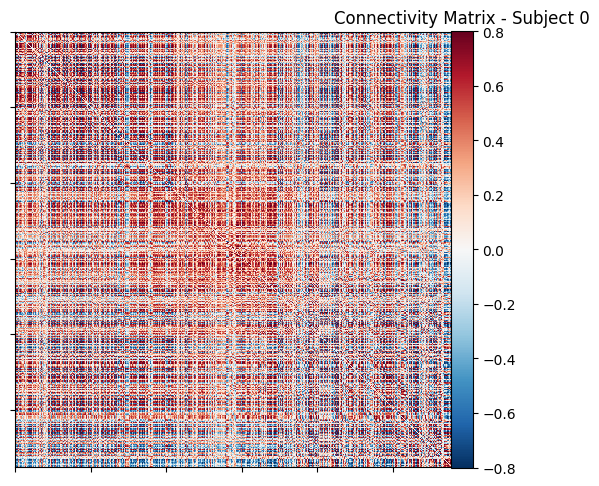

In [ ]:
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
import matplotlib.pyplot as plt
import numpy as np

subject_id = 0

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([masks[subject_id]])[0]

fig = plt.figure()

# Let's mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix,
                     colorbar=True,
                     vmax=0.8,
                     vmin=-0.8,
                     figure=fig)
plt.title(f'Connectivity Matrix - Subject {subject_id}')
plt.show()


**Precision**

By using the inverse covarience matrix (precision matrix )This will give us only the dirrect connections beween the regions since it contains partial covariance which is the covarience between 2 regionsconditioned on all the rest.
Here we will perform a functional connectome bassed on the precision score inorder to extract signals on ROI's of the first subject

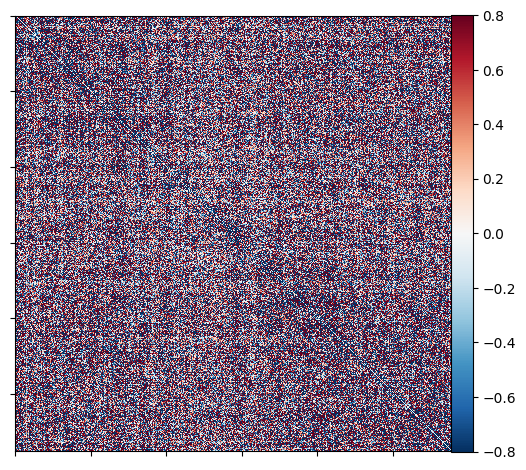

In [ ]:
correlation_measure = ConnectivityMeasure(kind='precision')
correlation_matrix = correlation_measure.fit_transform([masks[subject_id]])[0]

fig = plt.figure()

# Lets mask the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, colorbar=True,
                     vmax=0.8,
                     vmin=-0.8,
                     figure = fig)
plotting.show()

**Partial Correlation**

Partial correlation is great in accuratly detecting true brain network connections .Here we will perform functional connectivity analysis based on partial correlation and the visualizationdemostrates that the ventral tempral cortext of the first subjectis not much correlated

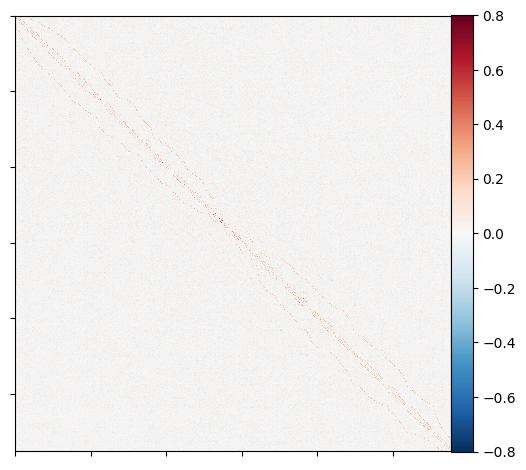

In [ ]:
correlation_measure = ConnectivityMeasure(kind='partial correlation')
correlation_matrix = correlation_measure.fit_transform([masks[subject_id]])[0]
fig = plt.figure()

#masking
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix,
                     colorbar=True,
                     vmax=0.8,
                     vmin=-0.8,
                     figure = fig)
plotting.show()

**Cosine Distance**

We perform cosine similarity analysis on the first subject this will help in the geodesic understanding in the context of statistical connections in the brain and the matrix obtained is visualized .This indicates that there are highly overlapping regions in terms of neural activity at the point the stimuli is presented

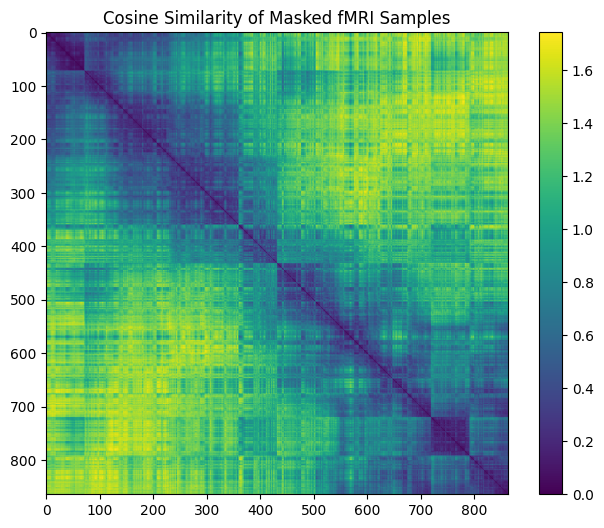

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.imshow(cdist(masks[subject_id], masks[subject_id], metric='cosine'))
plt.colorbar()
plt.title('Cosine Similarity of Masked fMRI Samples')
plt.show()

**Minkowski Distance**

Now we utilize minkowski ,which is generalization of bith Euclidean and Manhattan distance making it usefull in temporal similarity analysis

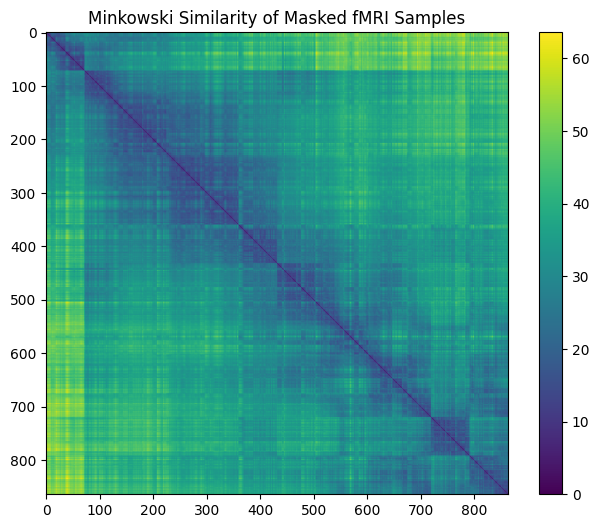

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.imshow(cdist(masks[subject_id], masks[subject_id], metric='minkowski'))
plt.colorbar()
plt.title('Minkowski Similarity of Masked fMRI Samples')
plt.show()

**Euclidean Distance**

Now we perform the similarity analysis based on classical euclidian distance.Whichis described as the classical measure of th distance in terms of cartesian coordinates of the points using pythagorean thoerm.From the results we conclude that neural activity invokedin the ventral tempral cortex of the brain is highly overlapping and also didtributed

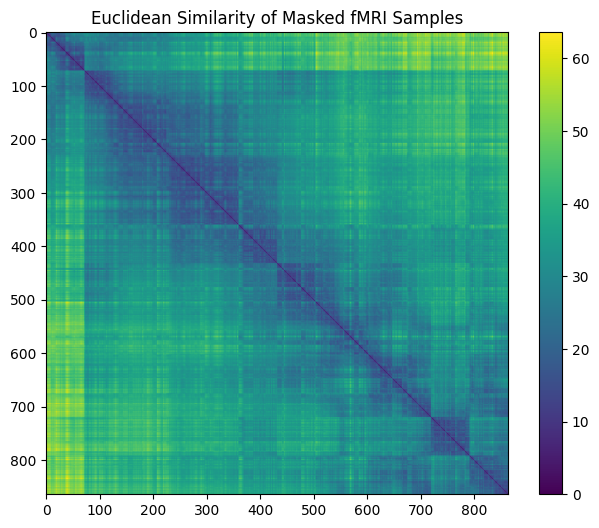

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.imshow(cdist(masks[subject_id], masks[subject_id]))
plt.colorbar()
plt.title('Euclidean Similarity of Masked fMRI Samples')
plt.show()

##Unsupervised Representation Learning on Distributed Regions in the Human Brain

Visual stimuli transfomations

Lets visualize the latent space in 2d AND 3D

In [ ]:
scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

In [ ]:
def plot_2d(component1:np.ndarray, component2:np.ndarray,path:str, y = None, ) -> None:

    fig = go.Figure(data=go.Scatter(
        x = component1,
        y = component2,
        mode='markers',
        marker=dict(
            size=20,
            color=y,
            colorscale='Rainbow',
            showscale=True,
            line_width=1
        )
    ))
    fig.update_layout(margin=dict(l=100,r=100,b=100,t=100),width=2000,height=1200)
    fig.layout.template = 'plotly_dark'

    fig.show()


    fig.write_image(path)


In [ ]:
def plot_3d(component1 : np.ndarray,
            component2 : np.ndarray,
            component3 :np.ndarray,
            path:str,
            y = None) -> None:

    fig = go.Figure(data=[go.Scatter3d(
            x=component1,
            y=component2,
            z=component3,
            mode='markers',
            marker=dict(
                size=10,
                color=y,
                colorscale='Rainbow',
                opacity=1,
                line_width=1
            )
        )])

    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1800,height=1000)
    fig.layout.template = 'plotly_dark'

    fig.show()
    fig.write_image(path)

**Dimensionality Reduction: PCA**

Here we performed PCA on the ROI's subject 5


In [ ]:
!pip install -U kaleido

In [ ]:
subject_id = 5
x = masks[subject_id]
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)

principal = pd.DataFrame(data = principalComponents
             ,columns = ['principal component 1',
                         'principal component 2',
                         'principal component 3'])

plot_2d(principalComponents[:, 0],
        principalComponents[:, 1],
        y = categories[subject_id],
        path = os.path.join(explanatory_fMRI_dir, 'pca_2d.png')
       )


In [ ]:
plot_3d(principalComponents[:, 0],
        principalComponents[:, 1],
        principalComponents[:, 2],

        y = categories[subject_id],
        path = os.path.join(explanatory_fMRI_dir, 'pca_3d.png')
       )

**Dimension Reduction: LDA**

This aims to find linear subspace which characterizes the original data space.Her we perform  LDA on subject 5 .From the results we can see that LDA is outperforming other metodsby seperating geodesic distance in the main folds


In [ ]:
x = masks[subject_id]
y = categories[subject_id]

X_LDA = LDA(n_components=3).fit_transform(x,y)

plot_3d(X_LDA[:, 0],
        X_LDA[:, 1],
        X_LDA[:, 2],
        path = os.path.join(explanatory_fMRI_dir, 'lda_3d.png'),
        y = categories[subject_id]
        )

**Dimension Reduction: ICA**

This is an approach for separating multivariate signals into there addictive components

In [ ]:
fast_ica = FastICA(n_components = 3)
ICs = fast_ica.fit_transform(x)


plot_3d(ICs[:, 0],
        ICs[:, 1],
        ICs[:, 2],
        path = os.path.join(explanatory_fMRI_dir, 'ica_3d.png'),
        y = categories[subject_id]
        )

**Dimension Reduction: NNMF**

This will be useful in extracting natural linear subspaces of original data samples.

In [ ]:
nmf = NMF(n_components = 3, max_iter=500)
MFs = nmf.fit_transform(minmax_scaler.fit_transform(x))

plot_3d(MFs[:, 0],
        MFs[:, 1],
        MFs[:, 2],
        path = os.path.join(explanatory_fMRI_dir, 'nnmf_3d.png'),
        y = categories[subject_id]
        )

**Manifold Learning: MDS**

This ia an approach for extracting non-linear sub-spaces of the original data space by preserving geodesic distance in the mainfold

In [ ]:
from sklearn.manifold import MDS

embedding = MDS(n_components=3)
manifold = embedding.fit_transform(x,categories[subject_id])

plot_3d(manifold[:, 0],
        manifold[:, 1],
        manifold[:, 2],
        path = os.path.join(explanatory_fMRI_dir, 'mds_3d.png'),
        y = categories[subject_id]
        )

**Manifold Learning: t-SNE**
This is a way of producing non-linear embedding of the original data space by preserving small pairwise distances or localized similarities

In [ ]:
x = masks[subject_id]

tsne = TSNE(random_state = 42,
            n_components=3,
            verbose=0,
            perplexity=40,
            n_iter=400).fit_transform(x)

plot_3d(tsne[:, 0],
        tsne[:, 1],
        tsne[:, 2],
        path = os.path.join(explanatory_fMRI_dir, 'tsene_3d.png'),
        y = categories[subject_id])

**Manifold Learning: UMAP**

its a non linear embeding approach that outperforms t-SNE by a large margin

In [ ]:
!pip install umap-learn

In [ ]:
import umap
reducer = umap.UMAP(random_state=42,n_components=3)
embedding = reducer.fit_transform(x)


plot_3d(embedding[:, 0],
        embedding[:, 1],
        embedding[:, 2],
         path = os.path.join(explanatory_fMRI_dir, 'umap_3d.png'),
        y = categories[subject_id])

**Manifold Learning: ISOMAP**

This is a non-linear embedding algorithm through isometric mapping for accurately estimating the intrinsic geometry of manifold by preserving geodesic distances in the manifold

In [ ]:
from sklearn.manifold import Isomap
x = masks[subject_id]

embedding = Isomap(n_components=3)
manifold = embedding.fit_transform(x)


plot_3d(manifold[:, 0],
        manifold[:, 1],
        manifold[:, 2],
        path = os.path.join(explanatory_fMRI_dir, 'isomap_3d.png'),
        y = categories[subject_id])

Mainfold Learning - LLE

This is a topology non-linear dimension reduction algorithm,which  preserves neighbor structure in the mainfold ,thus outperforming ISOMAP in optimization and speed .Now lets see the LLE visualization

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

embedding = LocallyLinearEmbedding(n_components=3)
manifold = embedding.fit_transform(x,categories[subject_id])

plot_3d(manifold[:, 0],
        manifold[:, 1],
        manifold[:, 2],
        path = os.path.join(explanatory_fMRI_dir, 'lle_3d.png'),
        y = categories[subject_id]
        )

Mainfold Learning:Spectral Embedding

This is a non-linear embedding algorithm that forms an affinity that forms an affinity matrix and applies spectral decomposition to the laplacian graph.

In [ ]:
from sklearn.manifold import SpectralEmbedding


embedding = SpectralEmbedding(n_components=3)
manifold = embedding.fit_transform(x)


plot_3d(manifold[:, 0],
        manifold[:, 1],
        manifold[:, 2],
        path = os.path.join(explanatory_fMRI_dir, 'SpectralEmbedding_3d.png'),
        y = categories[subject_id]
        )

###**Classical Machine Learning Agorithims and Neural networks**

Lazy Classifier

In [ ]:
# Load the data using joblib
fmri_imgs_mat = load('fMRI_data.joblib')
masks = load('masked_data.joblib')
categories = load('labels.joblib')

In [ ]:
!pip install -U mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.3 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.22.0
    Uninstalling mlxtend-0.22.0:
      Successfully uninstalled mlxtend-0.22.0


In [ ]:
from mlxtend.classifier import LazyClassifier
from sklearn.model_selection import train_test_split
import joblib
import os

results_dir = "your/path/to/results"  # Replace with your actual path

predictions_per_subject = list()

for subject_id, (fmri_img, category) in enumerate(zip(fmri_imgs_mat, categories)):
    print(f'Subject id: {subject_id}')

    X_train, X_test, y_train, y_test = train_test_split(fmri_img, category, test_size=0.3, random_state=42)

    Lclassifier = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, _ = Lclassifier.fit(X_train, X_test, y_train, y_test)

    # Print information about all models
    print(f'Available Models for Subject {subject_id}:')
    for model_name, model in models.models.items():
        print(f'Model: {model_name}')
        print(f'Parameters: {model.get_params()}')
        print()

    # Find the best model based on accuracy
    predictions = {}
    for model_name, model in models.models.items():
        y_test_pred = model.predict(X_test)
        predictions[model_name] = y_test_pred

    best_model_name = max(predictions, key=lambda k: accuracy_score(y_test, predictions[k]))
    best_model = models.models[best_model_name]

    # Make predictions using the best model
    y_test_pred = best_model.predict(X_test)
    predictions_per_subject.append((subject_id, y_test_pred))

    # Save the models using joblib or another suitable method
    joblib.dump(models, os.path.join(results_dir, f'Subject_{subject_id}_lazy_results.joblib'))

    print(f'Best Model: {best_model_name}')
    print(f'Predictions: {y_test_pred}')

# Print predictions for each subject
for subject_id, predictions in predictions_per_subject:
    print(f'Subject {subject_id} Predictions: {predictions}')


NameError: ignored

In [ ]:
predictions_per_subject = list()

for subject_is, (mask, category) in enumerate(zip(masks, categories)):
  print(f'Subject id: {subject_id}')

  X_train, X_test, y_train, y_test = train_test_split(mask, category, test_size = 0.3, random_state=42)
  Lclassifier = LazyClassifier(verbose=0,
                              ignore_warnings=True,
                              custom_metric=None
                              )
  models, predictions = Lclassifier.fit(X_train, X_test, y_train, y_test)
  models.to_csv(os.path.join(results_dir, f'Subject_{subject_id}_lazy_results.csv'))

  print(models)


Subject id: 5


 97%|█████████▋| 28/29 [02:04<00:15, 15.30s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116369
[LightGBM] [Info] Number of data points in the train set: 604, number of used features: 577
[LightGBM] [Info] Start training from score -2.169468
[LightGBM] [Info] Start training from score -2.021548
[LightGBM] [Info] Start training from score -1.996855
[LightGBM] [Info] Start training from score -2.046865
[LightGBM] [Info] Start training from score -2.099509
[LightGBM] [Info] Start training from score -2.113115
[LightGBM] [Info] Start training from score -2.126908
[LightGBM] [Info] Start training from score -2.072841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

100%|██████████| 29/29 [02:48<00:00,  5.80s/it]


                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
CalibratedClassifierCV             0.97               0.97    None      0.97   
PassiveAggressiveClassifier        0.96               0.96    None      0.96   
LinearSVC                          0.95               0.95    None      0.95   
RidgeClassifierCV                  0.95               0.95    None      0.95   
LogisticRegression                 0.94               0.94    None      0.94   
Perceptron                         0.92               0.92    None      0.92   
NuSVC                              0.92               0.92    None      0.92   
SGDClassifier                      0.87               0.88    None      0.87   
RandomForestClassifier             0.84               0.85    None      0.84   
LGBMClassifier                     0.84               0.84    None      0.84   
ExtraTreesClassifier               0.83 

 97%|█████████▋| 28/29 [01:10<00:11, 11.23s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93580
[LightGBM] [Info] Number of data points in the train set: 604, number of used features: 464
[LightGBM] [Info] Start training from score -2.260439
[LightGBM] [Info] Start training from score -2.059769
[LightGBM] [Info] Start training from score -1.984734
[LightGBM] [Info] Start training from score -2.034126
[LightGBM] [Info] Start training from score -2.072841
[LightGBM] [Info] Start training from score -2.099509
[LightGBM] [Info] Start training from score -2.086086
[LightGBM] [Info] Start training from score -2.059769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

100%|██████████| 29/29 [01:47<00:00,  3.72s/it]


                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LogisticRegression                 0.92               0.93    None      0.92   
CalibratedClassifierCV             0.89               0.90    None      0.89   
PassiveAggressiveClassifier        0.89               0.90    None      0.89   
NuSVC                              0.88               0.89    None      0.89   
LinearSVC                          0.88               0.89    None      0.87   
SGDClassifier                      0.87               0.87    None      0.87   
Perceptron                         0.83               0.84    None      0.83   
RidgeClassifierCV                  0.81               0.82    None      0.81   
SVC                                0.77               0.80    None      0.77   
ExtraTreesClassifier               0.76               0.77    None      0.76   
LGBMClassifier                     0.76 

 97%|█████████▋| 28/29 [00:41<00:06,  6.33s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61906
[LightGBM] [Info] Number of data points in the train set: 604, number of used features: 307
[LightGBM] [Info] Start training from score -2.099509
[LightGBM] [Info] Start training from score -2.009125
[LightGBM] [Info] Start training from score -2.113115
[LightGBM] [Info] Start training from score -2.059769
[LightGBM] [Info] Start training from score -2.126908
[LightGBM] [Info] Start training from score -2.126908
[LightGBM] [Info] Start training from score -2.086086
[LightGBM] [Info] Start training from score -2.021548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
NuSVC                              0.79               0.80    None      0.79   
CalibratedClassifierCV             0.76               0.77    None      0.76   
LogisticRegression                 0.75               0.75    None      0.75   
Perceptron                         0.74               0.75    None      0.74   
PassiveAggressiveClassifier        0.74               0.75    None      0.74   
RidgeClassifierCV                  0.73               0.74    None      0.72   
SVC                                0.73               0.74    None      0.73   
LinearSVC                          0.72               0.73    None      0.71   
SGDClassifier                      0.70               0.70    None      0.70   
LinearDiscriminantAnalysis         0.68               0.69    None      0.68   
LGBMClassifier                     0.68 

 97%|█████████▋| 28/29 [01:57<00:16, 16.02s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 604, number of used features: 675
[LightGBM] [Info] Start training from score -2.099509
[LightGBM] [Info] Start training from score -2.046865
[LightGBM] [Info] Start training from score -2.126908
[LightGBM] [Info] Start training from score -2.126908
[LightGBM] [Info] Start training from score -2.046865
[LightGBM] [Info] Start training from score -2.046865
[LightGBM] [Info] Start training from score -2.021548
[LightGBM] [Info] Start training from score -2.126908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

100%|██████████| 29/29 [02:48<00:00,  5.82s/it]


                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
NuSVC                              0.87               0.88    None      0.87   
PassiveAggressiveClassifier        0.88               0.87    None      0.88   
LogisticRegression                 0.87               0.87    None      0.87   
CalibratedClassifierCV             0.86               0.85    None      0.86   
Perceptron                         0.85               0.85    None      0.85   
LinearSVC                          0.85               0.84    None      0.85   
SGDClassifier                      0.82               0.81    None      0.81   
RidgeClassifierCV                  0.80               0.79    None      0.79   
ExtraTreesClassifier               0.73               0.73    None      0.73   
XGBClassifier                      0.73               0.73    None      0.73   
LGBMClassifier                     0.73 

 97%|█████████▋| 28/29 [01:00<00:08,  8.75s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78070
[LightGBM] [Info] Number of data points in the train set: 554, number of used features: 422
[LightGBM] [Info] Start training from score -2.127510
[LightGBM] [Info] Start training from score -2.068669
[LightGBM] [Info] Start training from score -2.158282
[LightGBM] [Info] Start training from score -2.083058
[LightGBM] [Info] Start training from score -1.973359
[LightGBM] [Info] Start training from score -2.026705
[LightGBM] [Info] Start training from score -2.054485
[LightGBM] [Info] Start training from score -2.158282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

100%|██████████| 29/29 [01:28<00:00,  3.04s/it]


                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
CalibratedClassifierCV             0.87               0.87    None      0.87   
PassiveAggressiveClassifier        0.87               0.87    None      0.87   
LinearSVC                          0.87               0.86    None      0.87   
LogisticRegression                 0.86               0.85    None      0.86   
NuSVC                              0.85               0.85    None      0.85   
SGDClassifier                      0.84               0.84    None      0.84   
RidgeClassifierCV                  0.81               0.81    None      0.81   
Perceptron                         0.78               0.77    None      0.78   
SVC                                0.75               0.75    None      0.75   
KNeighborsClassifier               0.73               0.73    None      0.73   
LGBMClassifier                     0.74 

 97%|█████████▋| 28/29 [00:48<00:06,  6.48s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70166
[LightGBM] [Info] Number of data points in the train set: 604, number of used features: 348
[LightGBM] [Info] Start training from score -2.155079
[LightGBM] [Info] Start training from score -2.198882
[LightGBM] [Info] Start training from score -2.021548
[LightGBM] [Info] Start training from score -2.059769
[LightGBM] [Info] Start training from score -2.140894
[LightGBM] [Info] Start training from score -1.996855
[LightGBM] [Info] Start training from score -2.072841
[LightGBM] [Info] Start training from score -2.009125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

100%|██████████| 29/29 [01:17<00:00,  2.66s/it]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
CalibratedClassifierCV             0.84               0.84    None      0.84   
PassiveAggressiveClassifier        0.82               0.83    None      0.82   
LogisticRegression                 0.82               0.82    None      0.82   
RidgeClassifierCV                  0.82               0.82    None      0.82   
LinearSVC                          0.81               0.81    None      0.81   
Perceptron                         0.80               0.80    None      0.80   
LinearDiscriminantAnalysis         0.78               0.79    None      0.79   
SGDClassifier                      0.78               0.78    None      0.78   
NuSVC                              0.77               0.77    None      0.77   
RidgeClassifier                    0.74               0.75    None      0.74   
SVC                                0.73 

We can asses the perfomance this way

Lets check for the Test set

Lets create a confusion matrix for the results

In [ ]:
import sys
import numpy as np
from sklearn.metrics import confusion_matrix

#sys.path.join(results_dir, 'CmLc.png')
import visualization
cm_Lc = confision_matrix(y_test, y_test_pred)
model_conf_matrix = cm_Lc.astype('float') / cm_Lc.sum(axis=1)[:, np.newaxis]

visualization.conf_matrix(model_conf_matrix,
                          categories,
                          title='LazyClassifier decoding on the Haxby data')


ModuleNotFoundError: ignored

Visualizing the weights

Here we can see which regions of the brain wilh have a large impact

In [ ]:
coef_img = masker.inverse_transform(Lclassifier.coef_[0, :])
plotting.view_img(
    coef_img, bg_img = haxby_dataset.anat[0],
    title="LazyClassifier weights", dim=-1, resampling_interpolation='nearest'
)

Now we can use high-level Decoder object from Nilearn

In [ ]:
from nilearn.decoding import Decoder
func_file= haxby_dataset.func[0]
#use func_file / numpy_fmri incase of issues
decoder = Decoder(estimator='svc', cv=10, mask= masker scoring = 'f1')
decoder.fit(numpy_fmri,conditions)

Now lets see the results of the f1 score

In [ ]:
print('F1 scores')
for category in categories:
  print(category, '\t\t {:.2f}'.format(np.mean(decorder.cv_scores_[category])))
plotting.view_img(
    decoder.coef_img_['face'], bg_img=haxby_dataset.anat[0],
    title="SVM weights for face", dim=-1, resampling_interpolation='nearest'
)

Brain decoding with svm
We are going to train a support vector machine classifier for brain decoding on the Haxby dataset ,since it is often suscesfull in high dimensional spaces .The objctive is to find the hypeplane within the maximum margin(is the distance between data points of both classes)

In [ ]:
from nilearn.decoding import FREMClassifier
from nilearn.image import index_img

models_path = os.path.join(root_dir,'models')
num_subjects = 6

for subject_id in range(num_subjects):
  print(f'Subject id :' {subject_id})

    behavioral = pd.read_csv(haxby_dataset.session_target[subject_id], sep='')
    conditions = behavioural['labels']
    condition_mask = conditions.isin([*stimuli2category])
    #Lets split the data into the training and testing by chunks
    condition_mask_train = (condition_mask) & (behavioral['chunks'] <= 8)
    condition_mask_test = (condition_mask) & (behavioral['chunks'] > 8)

    filenames = haxby_dataset.func[subject_id]
    X_train = index_img(filenames, condition_mask_train)
    X_test = index_img(filenames, condition_mask_test)
    y_train = conditions[condition_mask_train].values
    y_test = conditions[condition_mask_test].values

    masker = NiftiMasker(mask_img=haxby_dataset.mask_vt[subject_id],
                                                smoothing_fwh=4,
                                                standardize=True,
                                                memory='nilearn_cache',
                                                memory_level=1)

    decoder = FREMClassifier(estimator='svc',
                             cv=10, mask = masker

                             )
    #model fitting
decoder.fit(X_train, y_train)

y_pred = decoder.predict(X_test)

report = pd.DataFrame(classification_report(y_test, y_pred, output_dict = True)).T
report.to_csv(os.path.join(results-dir, f'Subject_{subject_id}_FREM_results.csv'))
# lets save our results
scores = pd.DataFrame(decoder.cv_scores_).T
scores.to_csv(os.path.join(results_dir, f'Subject_{subject_id}_FREMCV_results.csv'))

save_obj(decoder, os.path.join(models_path, f'Subject_{subject_id}_FREM_model'))


In [ ]:
print('F1 scoreswith FREM')
for category in categories:
  print(category. '\t\t {:.2f}'.format(np.mean(decoder.cv_scores_[category])))
  plotting.view_img(
      decoder.coef_img_['face'], bg_img=haxby_dataset.anat[0],
      title="FREM weights for faces" , dim=-1, resampling_interpolation='nearest'
  )


FREM(Logistic Regression - L2)

In [ ]:
from nilearn.decoding import FREMClassifier
from nilearn.image import index_img
from sklearn.model_selection import LeaveOneGroupOut
cv = LeaveOneGroupOut()

models_path = os.path.join(root_dir,'models')
num_subjects = 6

for subject_id in range(num_subjects):
  print(f'Subject id :' {subject_id})

    behavioral = pd.read_csv(haxby_dataset.session_target[subject_id], sep='')
    conditions = behavioural['labels']
    condition_mask = conditions.isin([*stimuli2category])


    filenames = haxby_dataset.func[subject_id]
    X_train = index_img(filenames, condition_mask)
    y_train = conditions[condition_mask].values


    masker = NiftiMasker(mask_img=haxby_dataset.mask_vt[subject_id],
                                                smoothing_fwh=4,
                                                standardize=True,
                                                memory='nilearn_cache',
                                                memory_level=1)

    decoder = FREMClassifier(estimator='logistic_l2',
                             cv=10, mask = masker

                             )
    #model fitting
decoder.fit(X_train, y_train)




# lets save our results
scores = pd.DataFrame(decoder.cv_scores_).T
scores.to_csv(os.path.join(results_dir, f'Subject_{subject_id}_FREMLogisticRegressionCV_results.csv'))

save_obj(decoder, os.path.join(models_path, f'Subject_{subject_id}_FREMLogisticRegressionCV_model'))


Lets make some statistical map visualizations for the classifiers results

In [ ]:
image_results_dir = os.path.join(root_dir, "images/results")
models_path = os.path.join(root_dir, 'models')

subject_id = 5
decoder = load_obj(os.path.join(models_path, f'Subject_{subject_id}_FREM_model'))

weight_img =decoder.coef_img_['face']
filenames = haxby_dataset.func[subject_id]

plotting.plot_stat_map(weight_img
                       bg_img = mean_img(filenames)
                       title = f"FREM Accuracy Score For the face as a Stimuli: {np.mean(decoder.cv_scores_['face']).round(2)}",
                       cut_coords=(-52, -5),
                       display_mode='yz'

                       )
plotting.show()

In [ ]:
subject_id = 5
decoder = load_obj(os.path.join(models_path, f'Subject_{subject_id}_FREM_model'))

weight_img =decoder.coef_img_['house']
filenames = haxby_dataset.func[subject_id]

plotting.plot_stat_map(weight_img
                       bg_img = mean_img(filenames)
                       title = f"FREM Accuracy Score For the face as a Stimuli: {np.mean(decoder.cv_scores_['house']).round(2)}",
                       cut_coords=(-52, -5),
                       display_mode='yz'

                       )
plotting.show()

In [ ]:
subject_id = 3
decoder = load_obj(os.path.join(models_path, f'Subject_{subject_id}_FREM_model'))

weight_img =decoder.coef_img_['house']
filenames = haxby_dataset.func[subject_id]

plotting.plot_stat_map(weight_img
                       bg_img = mean_img(filenames)
                       title = f"FREM Accuracy Score For the face as a Stimuli: {np.mean(decoder.cv_scores_['house']).round(2)}",
                       cut_coords=(-52, -5),
                       display_mode='yz'

                       )
plotting.show()

Discriminating Weights

In [ ]:
subject_id = 0
decoder = load_obj(os.path.join(models_path, f'Subject_{subject_id}_FREM_model'))

weight = decoder.coef_img_["face"]

plotting.plot_stat_map(weight_img,
                       bg_img=haxby_dataset.anat[subject_id],
                       title = 'FREM l2 Discriminating weights',
                       dim = -1
                       )
plotting.show()

In [ ]:
subject_id = 3
decoder = load_obj(os.path.join(models_path, f'Subject_{subject_id}_FREM_model'))

weight = decoder.coef_img_["face"]

plotting.plot_stat_map(weight_img,
                       bg_img=haxby_dataset.anat[subject_id],
                       title = 'FREM l2 Discriminating weights',
                       )
plotting.show()

In [ ]:
subject_id = 2
decoder = load_obj(os.path.join(models_path, f'Subject_{subject_id}_FREM_model'))

weight = decoder.coef_img_["house"]

plotting.plot_stat_map(weight_img,
                       bg_img=haxby_dataset.anat[subject_id],
                       title = 'FREM l2 Discriminating weights',
                       )
plotting.show()

Now lets visualize the accuraccies





In [ ]:
def list2df(itrable):
  df = pd.Dataframe(iterable).T
  df.columns = cols
  return df


In [ ]:
average_df = None
cols = ['Model', 'Accuracy', 'Balanced Accuracy', ,'F1 Score', 'Time Taken']
accuracy_svc = 0
accuracy_logistic =0
num_subjects = 6

for subject_id in range(num_subjects):
  results_df = pd.read_csv(os.path.join(results_dir, f'Subject_{subject_id}_lazy_results.csv')).sort_values(by = 'Model')
  if subject_id == 0:
    average_df = results_df
  else:
    average_df = results_df

  results_df_frem = pd.read_csv(os.path.join(results_dir,f'Subject_{subject_id}_FREMCV_results.csv'))
  accuracy_svc += results_df_frem.mean(1).mean()

  results_df_frem_lr = pd.read_csv(os.path.join(results_dir, f'Subject_{subject_id}_FREMLogisticRegressionCV_results.csv'))
  accuracy_logistic += results_df_frem_lr.mean(1).mean()


accuracy_svc /= num_subjects
accuracy_svc = round(accuracy_svc, 2)
frem_col = ['FREM:SVCL2', accuracy_svc, accuracy_svc, accuracy_svc, '-']
frem = list2df(frem_col)

accuracy_logistic /= num_subjects
accuracy_logistic = round(accuracy_logistic, 2)
frem_col_lr = ['FREM:LRL2', accuracy_logistic, accuracy_logistic, accuracy_logistic, '-']
df_frem_lr = list2df(frem_col_lr)

cnn1 = ['2D CNN', 0.70, '-', '-','-']
cnn1 = ['3D CNN', 0.80, '-', '-','-']
cnn1 = ['Twin-SVT', 0.82, '-', '-','-']

dff_cnn1 = list2df(cnn1)
dff_cnn2 = list2df(cnn2)
dff_twin = list2df(twin)

average_df = average_df.drop('Model', axis = 1) / num_subjects
average_df['Model'] = results_df['Model']
average_df.drop('ROC AUC', AXIS = 1 , inplace =True)
average_df = pd.concat([average_df, df_frem, df_frem_lr, df_cnn1, df_cnn2, df_twin ])




